<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/nn-02-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with TensorFlow 2 Keras Layers

## Objectives

- activation functions
- classification

In [1]:
!pip install -q tensor-sensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

## A new challange: predicting a category instead of a continous value

* so far we were inferring a continous value for another
* now we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binary classification

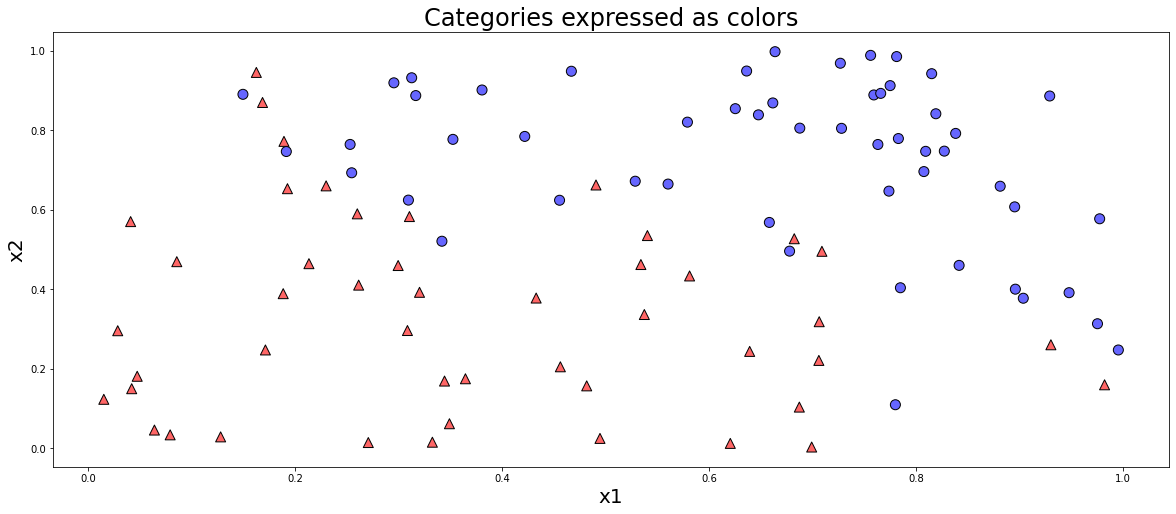

In [4]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 100 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import pandas as pd
import numpy as np

# np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF6666', '#6666FF'])

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='^', edgecolors='k', s=~y_bool*size);

### Can you think of an application for this? What could be on the axes?

_Let's adapt the example to something we can relate to_

## Training using so called 'Logictic Regression'

In [5]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.3.0'

In [6]:
tf.random.set_seed(42)

In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### We have two dimensions as input now

In [8]:
X.shape, y.shape

((100, 2), (100,))

In [9]:
import tsensor

with tsensor.explain():
    X

findfont: Font family ['Consolas'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


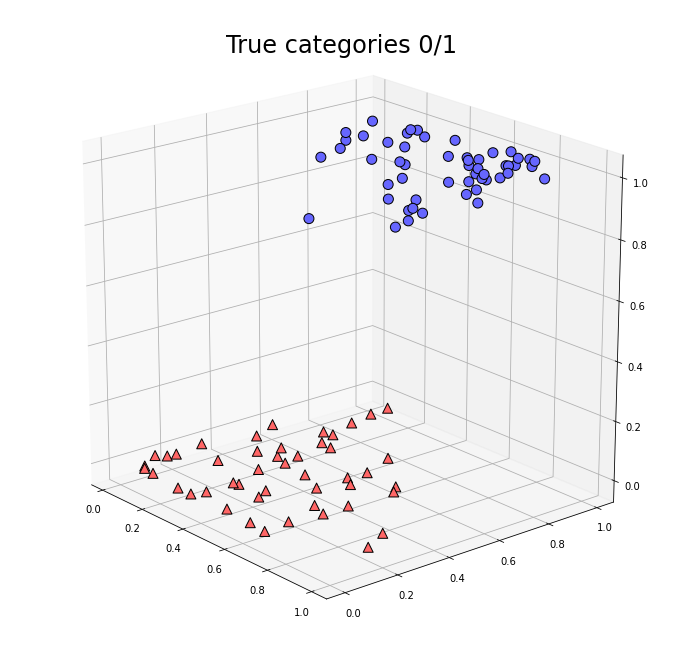

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('True categories 0/1')

# we can have the probability encoded in shade of color
ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=cmap,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y*size)

ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=cmap,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_bool*size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=20, azim=-40)

In [11]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')
x.shape, y.shape

(TensorShape([100, 2]), (100,))

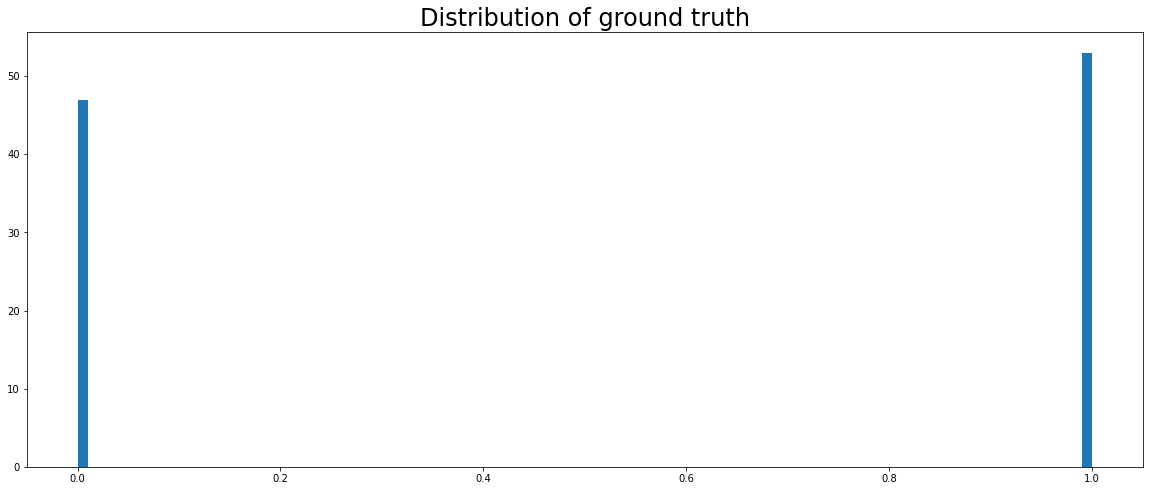

In [12]:
plt.hist(y, bins=n)
plt.title('Distribution of ground truth');

In [13]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time 

model.compile(loss='mse', 
             optimizer='sgd')

history = model.fit(x, y_true, epochs=1000, verbose=0)

CPU times: user 3.41 s, sys: 312 ms, total: 3.73 s
Wall time: 2.92 s


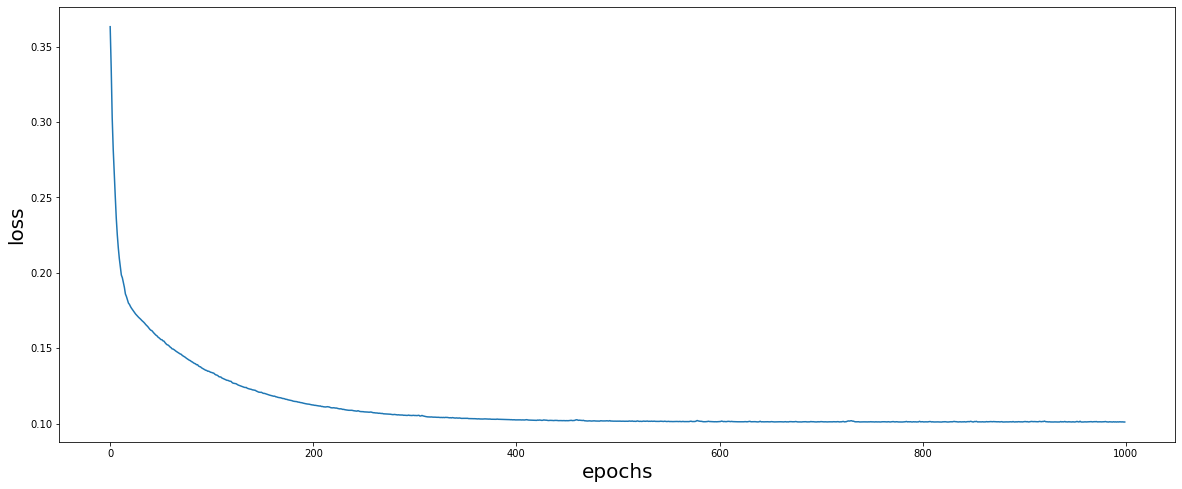

In [15]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);

### Loss converges, but how does the output look like?

In [16]:
y_pred = model.predict(x)

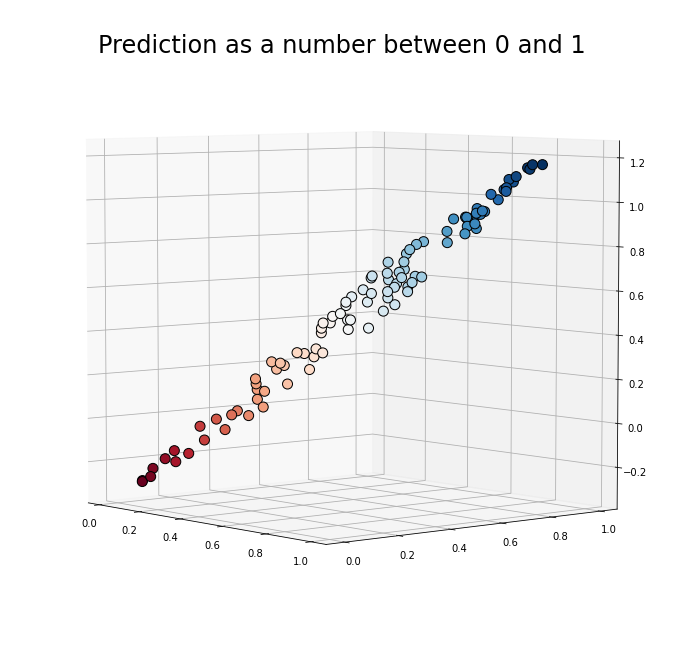

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Prediction as a number between 0 and 1')

# we can have the probability encoded in shade of color
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred.ravel(), 
           cmap=plt.cm.RdBu,
           marker='o', 
           depthshade=False,
           edgecolors='k',
           s=size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=5, azim=-40)
# ax.view_init(elev=10, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

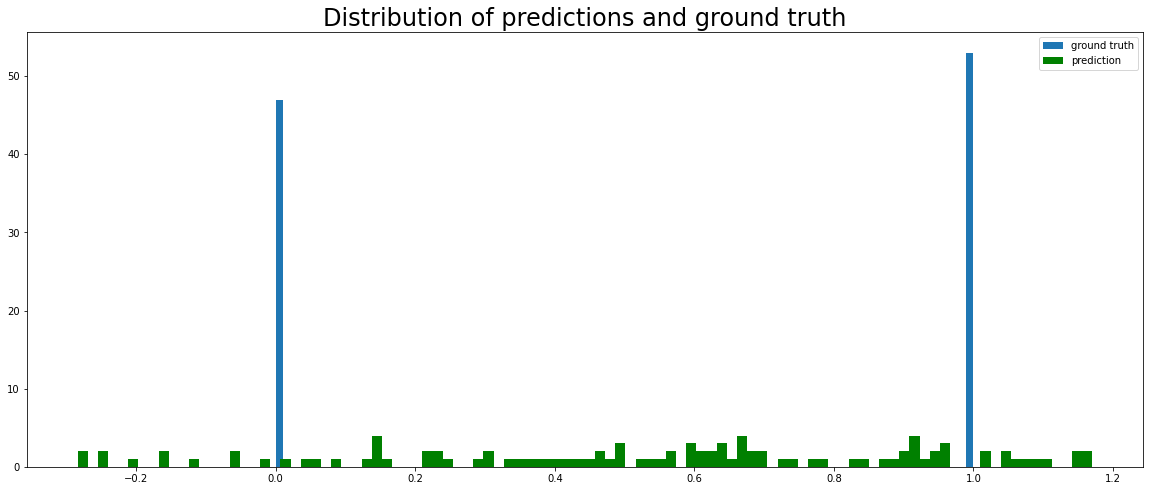

In [18]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions and ground truth');

### Turning a value between 0 and 1 into a binary decision

_everything below 0.5 counts as 0, everthing above as 1_

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf2/img/logistic.jpg?raw=1'>

In [19]:
threshold = 0.5

In [20]:
y_pred_binary = (y_pred > threshold).astype(int).ravel()
y_pred_binary

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

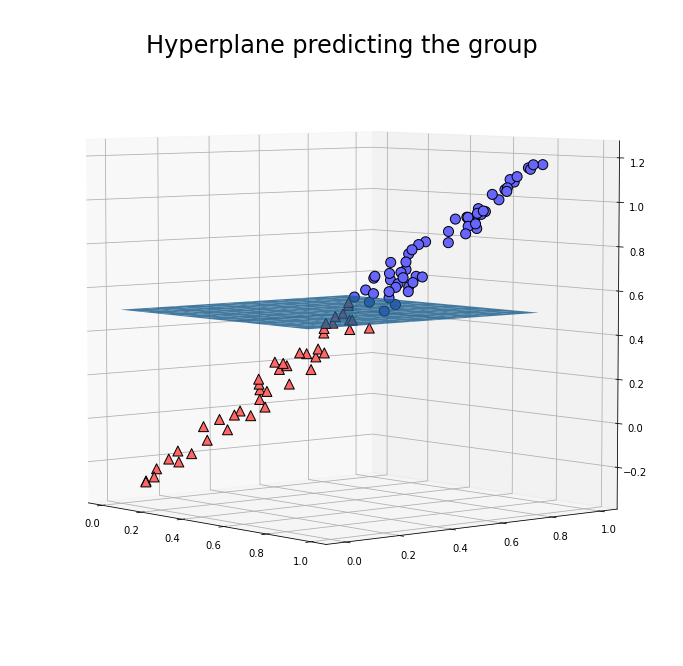

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hyperplane predicting the group')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred_binary,
           cmap=cmap,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

xx,yy = np.meshgrid(np.arange(0.0, 1.0, 0.1), np.arange(0.0, 1.0, 0.1))
zz = np.full(xx.shape, threshold)
ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

### Interpretation

* some values are negative
* some are above 1
* we have a lot of variance

### Is there a way to decrease variance of the prediction and actually compress the values between 0 and 1?

## Understandinging the effect of activation functions


Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ai/img/activation-functions.jpg'>


### We can use sigmoid as the activation function

In [22]:
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Reconsidering the loss function

_cross entropy is an alternative to mean squared error_ 

* cross entropy can be used as an error measure when a network's outputs can be thought of as representing independent hypotheses
* activations can be understood as representing the probability that each hypothesis might be true
* the loss indicates the distance between what the network believes this distribution should be, and what the teacher says it should be 
* in this case we are dealing with two exclusive hypothesis: either a sample is blue or it is red
* this makes this binary cross entropy
* using MSE will still work, but xent should give us steeper gradients leading to faster learning

https://en.wikipedia.org/wiki/Cross_entropy 

http://www.cse.unsw.edu.au/~billw/cs9444/crossentropy.html

### We also have a new metric: what share of predictions is correct?

* basic metric for classification: share of correctly predicted samples
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy


### Advanced Optimizer (pretty much standard)

In [23]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=2000, verbose=0)

CPU times: user 8.28 s, sys: 572 ms, total: 8.85 s
Wall time: 6.87 s


In [24]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.25817158818244934, 0.8799999952316284)

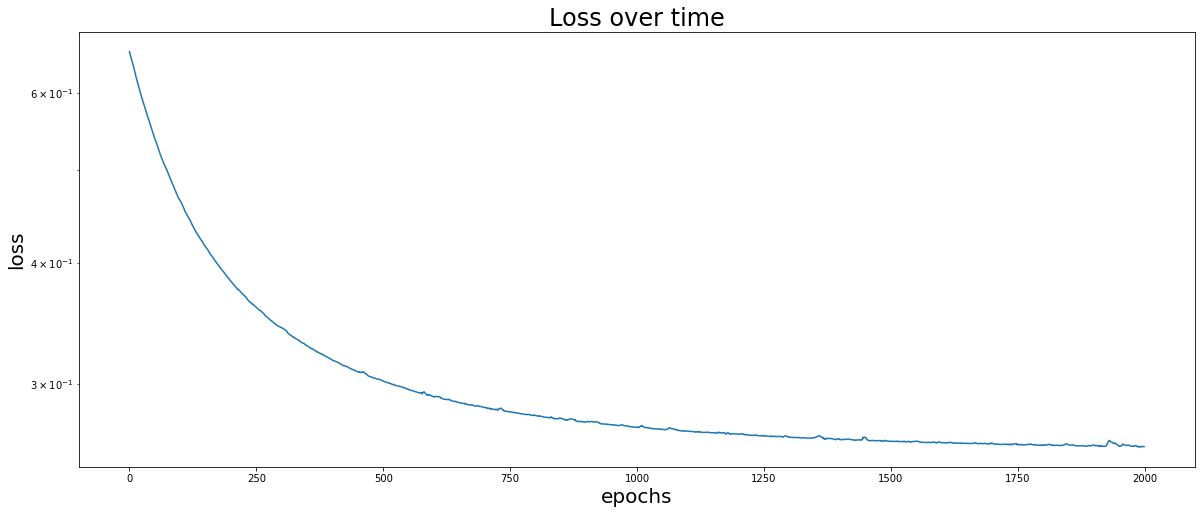

In [25]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

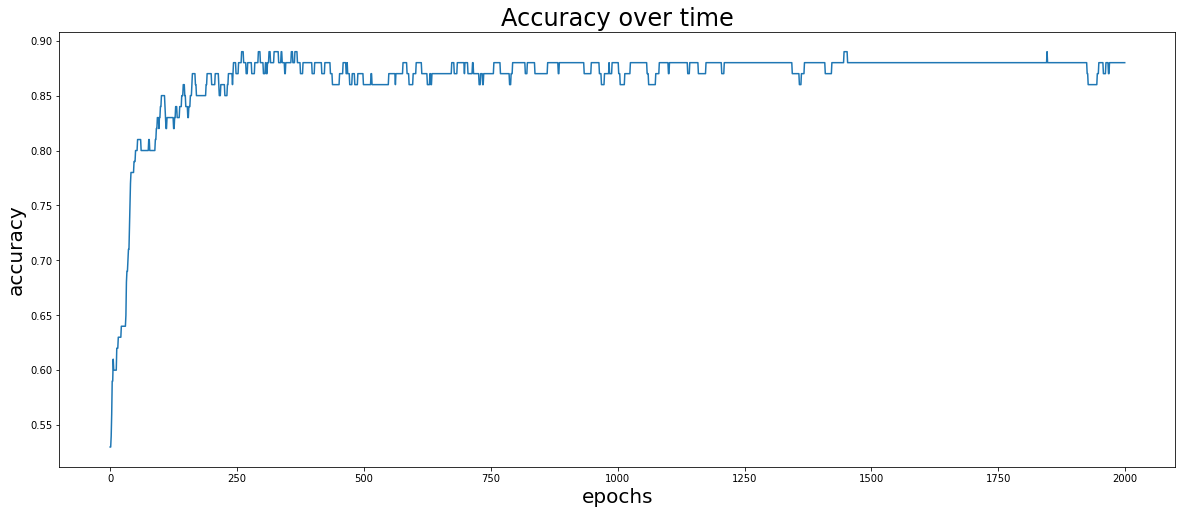

In [26]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [27]:
y_pred = model.predict(x)

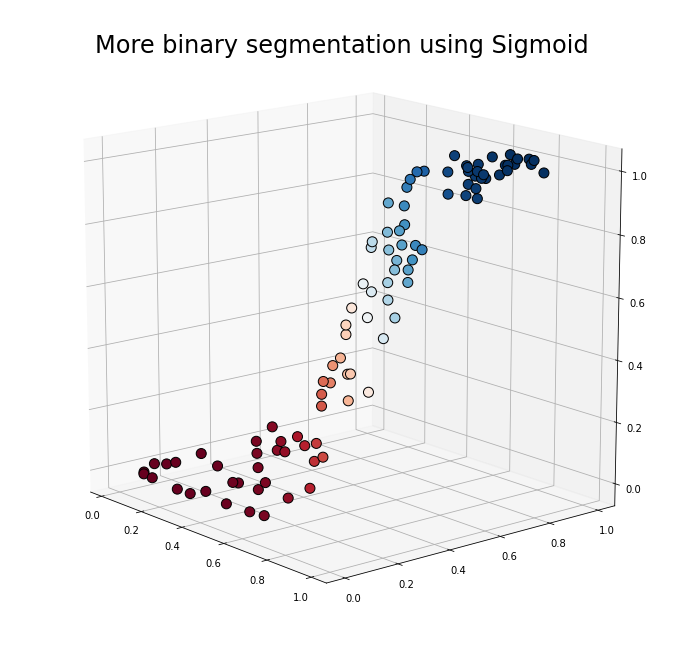

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('More binary segmentation using Sigmoid')

# we can have the probability encoded in shade of color
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred.ravel(), 
           cmap=plt.cm.RdBu,
           marker='o', 
           depthshade=False,
           edgecolors='k',
           s=size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=15, azim=-40)
# ax.view_init(elev=10, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

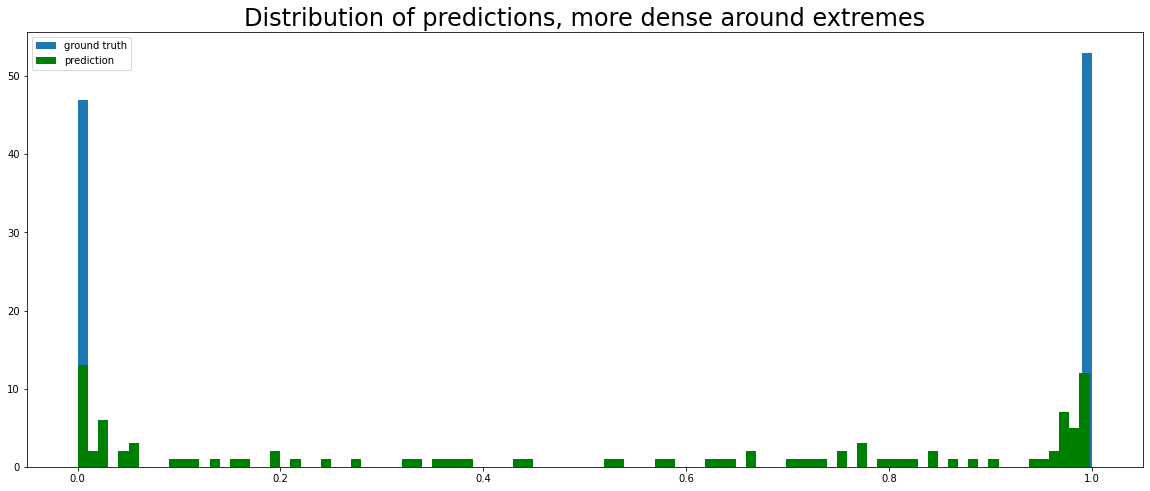

In [29]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, more dense around extremes');

In [30]:
y_pred_binary = (y_pred > threshold).astype(int).ravel()

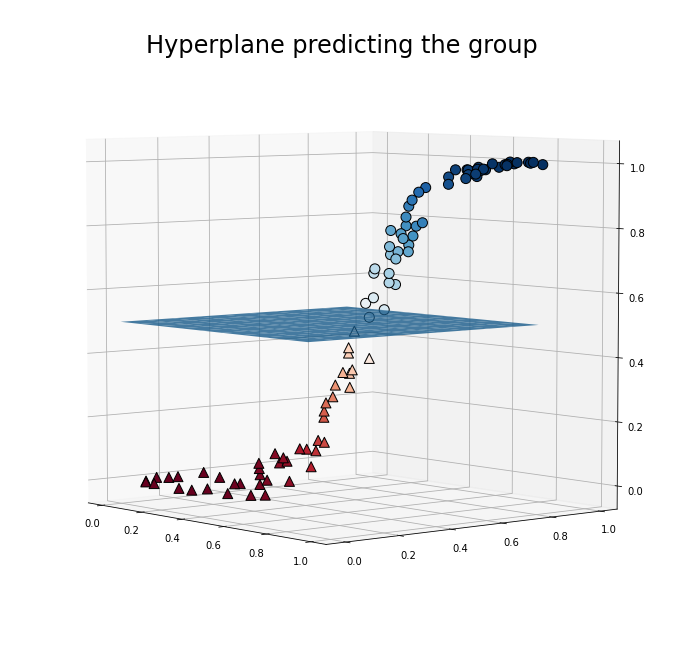

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hyperplane predicting the group')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

In [32]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = .05  # step size in the mesh
#     x_min, x_max = -0.1, 1.1
#     y_min, y_max = -0.1, 1.1

    x_min, x_max = x_data.min() - .1, x_data.max() + .1
    y_min, y_max = y_data.min() - .1, y_data.max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   ax=None, marker_size=100
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      _, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='o', edgecolors='k', s=classes*marker_size)
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='^', edgecolors='k', s=~classes.astype(bool)*marker_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    return ax


Instructions for updating:
Please use `model.predict()` instead.


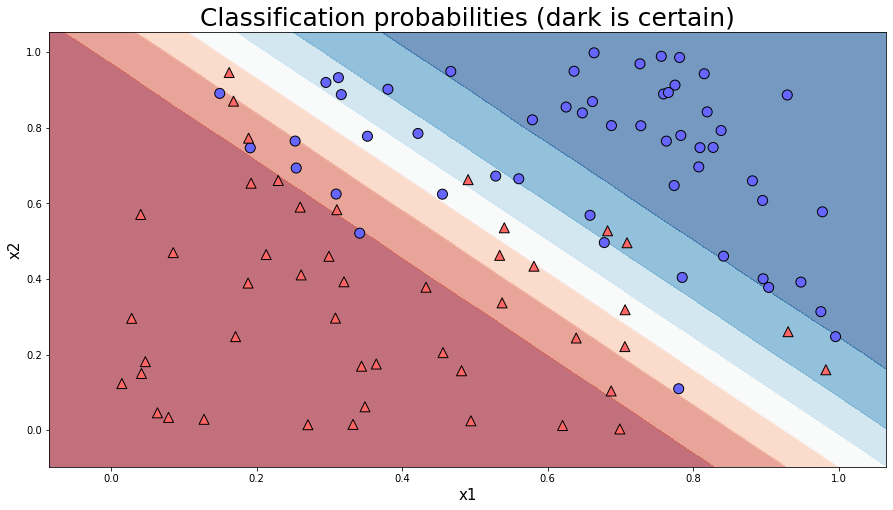

In [33]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities (dark is certain)");

### Hands-On: run this classification experiment

* generated your own dataset using a bit more noise
* train the model and generate all the plots
* does all this make sense to you?
* change the threshold in the final example from 0.5 to anything else, how does the result change?
* use different activation functions

_advanced_: can a hidden layer improve the quality of prediction?

* use the playground to experiment with hidden layers
* under the hood the playground also uses a final neuron with tanh activation to decide between the two categories
* you add additional hidden layers to the model im the same way you would with the regression example

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential


## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/

## Deep Learning: Neural Networks with 2-3 Layers can learn to draw any decision boundary or approximate any continuous function


In [34]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1000, verbose=0)

CPU times: user 8.25 s, sys: 708 ms, total: 8.95 s
Wall time: 6.22 s


In [36]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.21059279143810272, 0.8799999952316284)

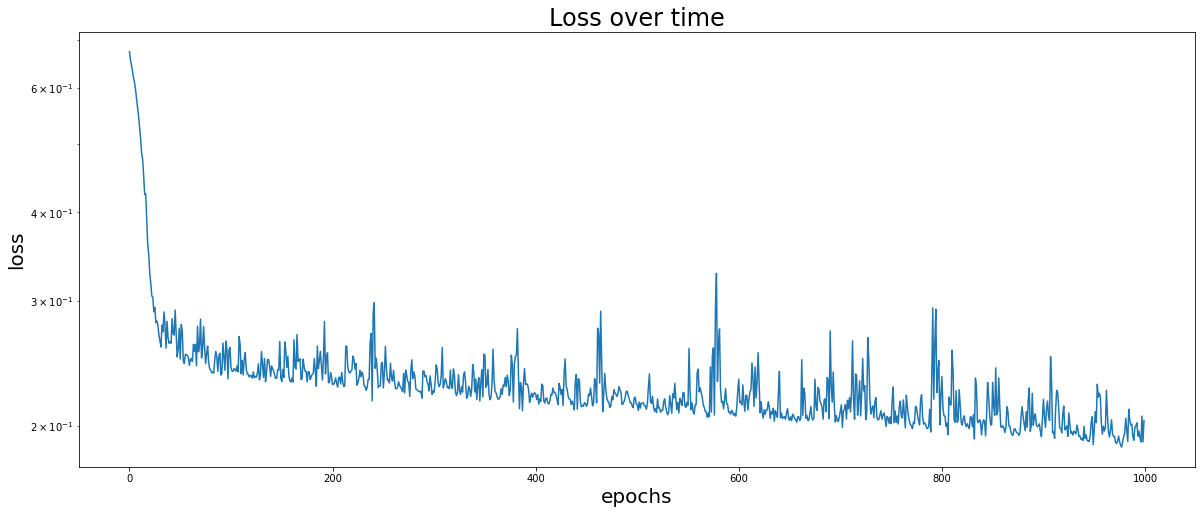

In [37]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

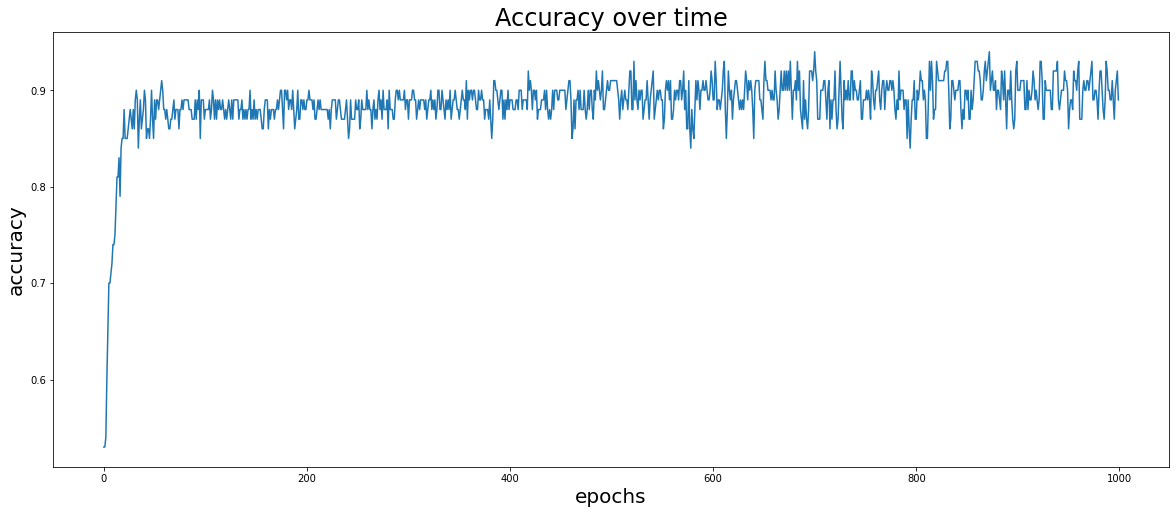

In [38]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [39]:
y_pred = model.predict(x)
y_pred_binary = (y_pred > threshold).astype(int).ravel()

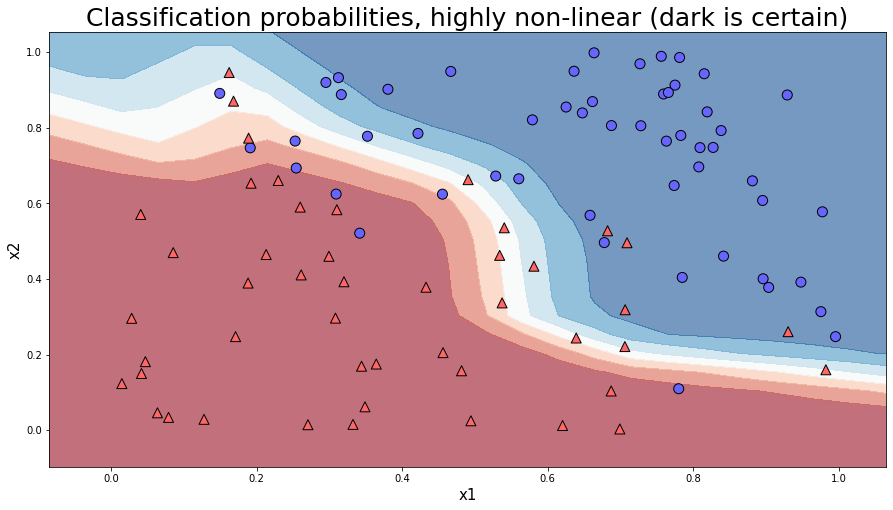

In [40]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y_true,
                title="Classification probabilities, highly non-linear (dark is certain)");

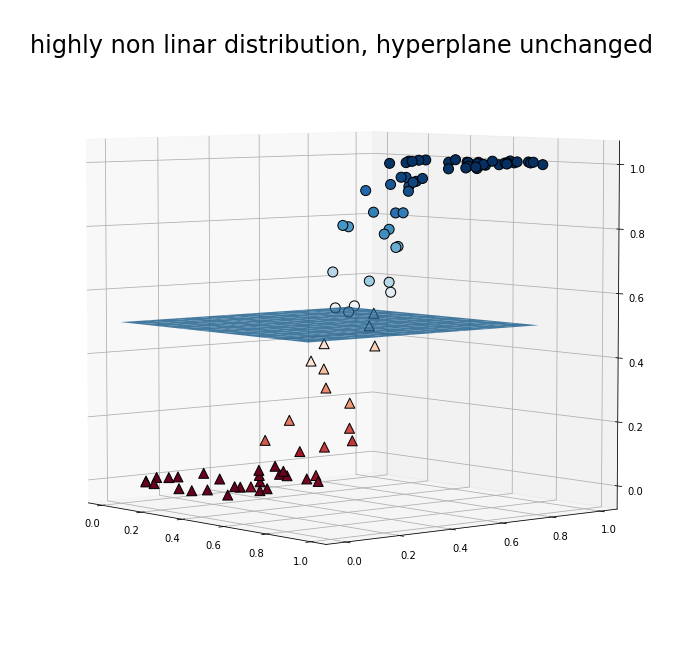

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('highly non linar distribution, hyperplane unchanged')

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y_pred_binary*size)

ax.scatter(X[:,0], X[:,1], y_pred, c=y_pred.ravel(),
           cmap=plt.cm.RdBu,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_pred_binary.astype(bool)*size)

ax.plot_surface(xx, yy, zz, alpha=0.8)

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-40)
ax.view_init(elev=5, azim=-40)

# also try to get a better idea how the hyperplane looks like
# ax.view_init(elev=20, azim=-75)
# ax.view_init(elev=10, azim=-40)

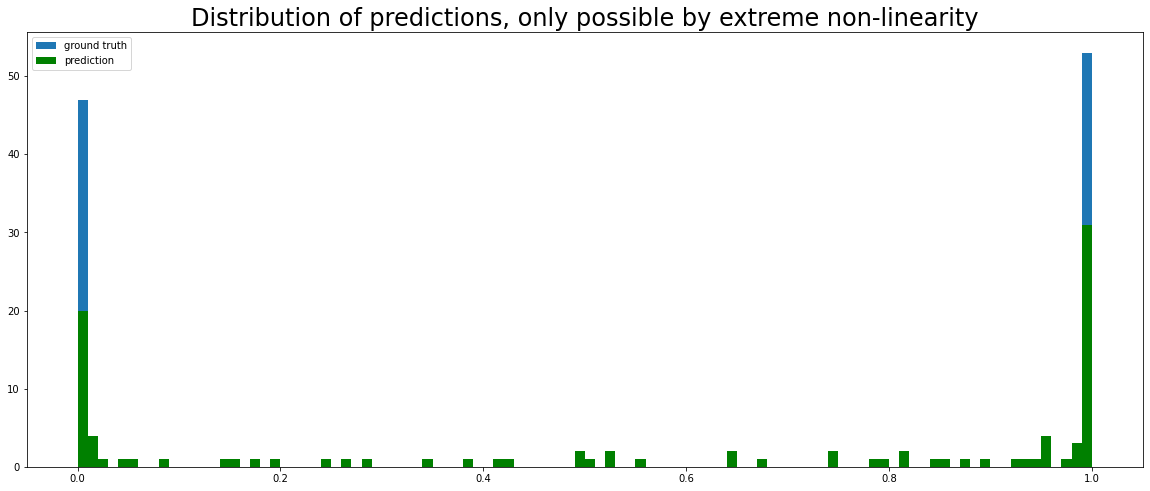

In [42]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, only possible by extreme non-linearity');

## Interpration of Deep Learning

* the final layer combines all previous inputs into a single prediction
  * either a linear transformation or
  * a binary prediction
* intermediate (hidden) layers transform the problem in way to make it linear or accessible to a logistic function
* ideally this replaces any manual feature engineering   

